## Toxicity EDA
Competition location:  
https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification  
Source code location:  
https://www.kaggle.com/dborkan/benchmark-kernel  
Credits to:
https://www.kaggle.com/thousandvoices/simple-lstm
https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

import os
import gc

# from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import gensim

from sklearn.model_selection import KFold

from keras.layers import *
from keras.initializers import *
from keras.constraints import *
from keras.regularizers import *
from keras.activations import *
from keras.optimizers import *
import keras.backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns

# from wordcloud import WordCloud ,STOPWORDS

In [15]:
train = pd.read_csv('/data/ToxicityData/train.csv')
test = pd.read_csv('/data/ToxicityData/test.csv')

In [16]:
train.iloc[5,:]

id                                                             59859
target                                                      0.666667
comment_text                                    ur a sh*tty comment.
severe_toxicity                                             0.047619
obscene                                                     0.638095
identity_attack                                                    0
insult                                                      0.333333
threat                                                             0
asian                                                            NaN
atheist                                                          NaN
bisexual                                                         NaN
black                                                            NaN
buddhist                                                         NaN
christian                                                        NaN
female                            

In [17]:
print("Length of training data", len(train))
print("Length of test data", len(test))


Length of training data 1804874
Length of test data 97320


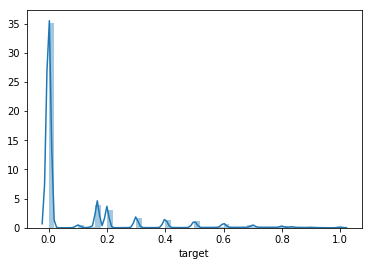

In [18]:
sns.distplot(train.target)

Most of the comments are not toxic, so this would be an imbalanced class prediction where accuracy does not make a lot of sense

In [19]:
print("proportion of >0.5 toxicity", len(train[train.target > 0.5])/len(train))
print("proportion of >0.0 toxicity", len(train[train.target > 0.0])/len(train))

proportion of >0.5 toxicity 0.05897253769515213
proportion of >0.0 toxicity 0.2992508064274847


In [20]:
from sklearn import datasets
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

In [21]:
from nltk.tokenize import WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()

## minimum pre-processing and embedding using glove and fasttext

In [22]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix
    

def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(MAX_LEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model
    

def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [23]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence



EMBEDDING_FILES = [
    '/data/embed/crawl-300d-2M.vec',
    '/data/embed/glove.840B.300d.txt'
]


x_train = preprocess(train['comment_text'])
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])


In [24]:
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220

In [25]:

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)
    
checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            callbacks=[
                LearningRateScheduler(lambda epoch: 1e-3 * (0.6 ** global_epoch))
            ]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)

predictions = np.average(checkpoint_predictions, weights=weights, axis=0)



Epoch 1/1
 - 735s - loss: 0.2380 - dense_7_loss: 0.1306 - dense_8_loss: 0.1073
Epoch 1/1
 - 733s - loss: 0.2178 - dense_7_loss: 0.1151 - dense_8_loss: 0.1028
Epoch 1/1
 - 735s - loss: 0.2118 - dense_7_loss: 0.1100 - dense_8_loss: 0.1018
Epoch 1/1
 - 733s - loss: 0.2075 - dense_7_loss: 0.1062 - dense_8_loss: 0.1013
Epoch 1/1
 - 736s - loss: 0.2380 - dense_11_loss: 0.1307 - dense_12_loss: 0.1073
Epoch 1/1
 - 735s - loss: 0.2176 - dense_11_loss: 0.1149 - dense_12_loss: 0.1027
Epoch 1/1
 - 736s - loss: 0.2116 - dense_11_loss: 0.1098 - dense_12_loss: 0.1018
Epoch 1/1
 - 736s - loss: 0.2070 - dense_11_loss: 0.1057 - dense_12_loss: 0.1012


In [26]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': predictions
})

submission.to_csv('submission.csv', index=False)

In [34]:
for i in range(5):
    print("i =", i)
    print("prediction", submission.iloc[i,1])
    print("sentence", test.iloc[i,1])    

i = 0
prediction 0.0018541306257247926
sentence Jeff Sessions is another one of Trump's Orwellian choices. He believes and has believed his entire career the exact opposite of what the position requires.
i = 1
prediction 2.6900569597880045e-05
sentence I actually inspected the infrastructure on Grand Chief Stewart Philip's home Penticton First Nation in both 2010 and 2013.  Exactly Zero projects that had been identified in previous inspection reports had been funded by the federal government, and the entire band was housed in ATCO trailers.  Clearly the Harper Conservatives had already reduced the cash his band was sent to zero.
i = 2
prediction 0.0057537813981374105
sentence No it won't . That's just wishful thinking on democrats fault .   For the 100 th time , Walker cited the cost of drug users treatment as being lost with Obamacare .  I laugh every time I hear a liberal claim republicans want to hurt people , and that's why they dumped Obamacare.
i = 3
prediction 0.0027022322018941

In [36]:
for i in range(100):
    if  submission.iloc[i,1] < 0.5:
        continue
    else: 
        print("i =", i)
        print("prediction", submission.iloc[i,1])
        print(test.iloc[i,1])  

i = 4
prediction 0.9776043395201365
how many of you commenters have garbage piled high in your yard, bald tires, dead batteries, rotten pallets, car parts, blah blah blah. this town is a pigpen. drive around and look for yourself, its pathetic.
i = 24
prediction 0.9399931748708089
Corrupt hypocrites throughout he government. Of the money, by the money and for the money. Brought to you by the jesus freaks cause birds of a feather flock together.
i = 55
prediction 0.9726092259089152
Fool.
i = 90
prediction 0.9952839493751526
LIAR LIAR PANTS ON FIRE......how dumb does he think we are.  We think justin is extremely dumb.  What a goof ball. He is gets in deeper and deeper over his head.  Time to hold him up as an adult and stop allowing him to think and speak.


how offensive is offensive? Especially in political discussions, opposing party's comment can often appear offensive